In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('BF_df_CTU.csv')
data.head()

,EX1G,EX2G,A1G,A2G,C1G,C2G,ES1G,ES2G,O1G,O2G,CONDITION
0,4,4,4,4,4,5,4,4,4,4,H
1,4,2,2,4,4,5,3,4,4,4,H
2,4,2,2,4,4,4,3,4,4,4,H
3,4,2,2,4,2,4,5,5,4,2,H
4,3,2,3,4,5,5,4,4,5,5,H


In [3]:
n=len(data)

In [4]:
x_real = data.iloc[:n//2,:-1]
x_fake = data.iloc[n//2:,:-1]

In [5]:
index = np.random.choice([0,1,2], size=n//2, p=[0.8,0.1,0.1])

In [6]:
x_real_train = x_real[index==0]
x_real_val = x_real[index==1]
x_real_test = x_real[index==2]

x_fake_train = x_fake[index==0]
x_fake_val = x_fake[index==1]
x_fake_test = x_fake[index==2]

# Naive approach

All the proposed method should outperform the trivial strategy of subtracting to each subject faked response the average of the difference, across all subjects, among faked and honest response.

In [7]:
mean_train = (x_fake_train.to_numpy() - x_real_train.to_numpy()).mean(axis=0)
test_mse = (((x_fake_test.subtract(mean_train)).to_numpy() - x_real_test.to_numpy())**2).mean()
test_mse

1.4906668983737246

# Denoising autoencoder

In [61]:
dim_1 = 6
dim_2 = 3

input_vector = tf.keras.layers.Input(shape=(10,))

# Define the encoder
hidden_1 = tf.keras.layers.Dense(dim_1, activation='sigmoid')(input_vector)
encoded = tf.keras.layers.Dense(dim_2, activation='sigmoid')(hidden_1)

# ...and the decoder...
hidden_2 = tf.keras.layers.Dense(dim_1, activation='sigmoid')(encoded)
decoded = tf.keras.layers.Dense(10, activation='linear')(hidden_2)

# and finally the autoencoder
autoencoder = tf.keras.models.Model(inputs=input_vector, outputs=decoded)

autoencoder.compile(optimizer='adam', loss='mse')

In [62]:
autoencoder.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 10)]              0         
_________________________________________________________________
dense_30 (Dense)             (None, 6)                 66        
_________________________________________________________________
dense_31 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_32 (Dense)             (None, 6)                 24        
_________________________________________________________________
dense_33 (Dense)             (None, 10)                70        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [63]:
history = autoencoder.fit(x_fake_train, x_real_train, epochs=300, shuffle=True, validation_data=(x_fake_val, x_real_val))

Epoch 1/300
6/6 [==============================] - 0s 40ms/step - loss: 12.2255 - val_loss: 12.7404
Epoch 2/300
6/6 [==============================] - 0s 6ms/step - loss: 12.0444 - val_loss: 12.5563
Epoch 3/300
6/6 [==============================] - 0s 9ms/step - loss: 11.8636 - val_loss: 12.3736
Epoch 4/300
6/6 [==============================] - 0s 8ms/step - loss: 11.6852 - val_loss: 12.1920
Epoch 5/300
6/6 [==============================] - 0s 6ms/step - loss: 11.5088 - val_loss: 12.0114
Epoch 6/300
6/6 [==============================] - 0s 8ms/step - loss: 11.3323 - val_loss: 11.8325
Epoch 7/300
6/6 [==============================] - 0s 7ms/step - loss: 11.1573 - val_loss: 11.6552
Epoch 8/300
6/6 [==============================] - 0s 8ms/step - loss: 10.9835 - val_loss: 11.4797
Epoch 9/300
6/6 [==============================] - 0s 8ms/step - loss: 10.8132 - val_loss: 11.3054
Epoch 10/300
6/6 [==============================] - 0s 8ms/step - loss: 10.6418 - val_loss: 11.1335
Epoch 11

In [11]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

1/1 - 0s - loss: 1.1923
test mse: 1.19227


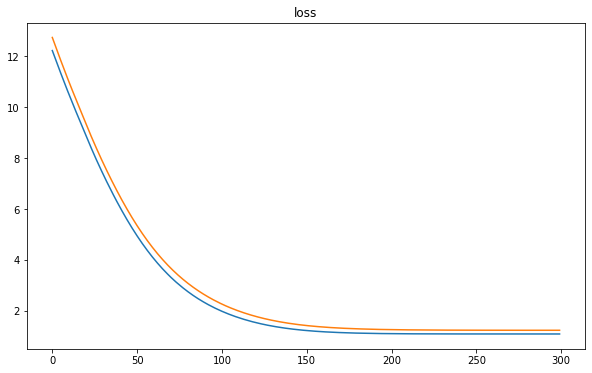

In [64]:
plot_loss(history)

scores = autoencoder.evaluate(x_fake_test, x_real_test, verbose=2)
print("test mse: %.5f" % (scores))

In [65]:
test_mse = ((autoencoder.predict(x_fake_test) - x_real_test.to_numpy())**2).mean()
test_mse

1.192271921293912